## Задание 1. Python

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

import requests
from urllib.parse import urlencode

In [2]:
def get_data_from_Yandex_disk(url, sep):
    """ 
    Возвращает df из файла с .csv-расширением, хранящегося на Яндекс-диске,
    url - путь на Яндекс-диск,
    sep - разделитель в файле csv
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
       
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    df = pd.read_csv(download_url, sep=sep)
    return df

In [3]:
# Загружаем файлы при помощи созданной функции
groups = get_data_from_Yandex_disk("https://disk.yandex.ru/d/jyT8UrFH3OtIHQ", sep=';')
group_add = get_data_from_Yandex_disk("https://disk.yandex.ru/d/hH_80polNPR4Ag", sep=',')
active_studs = get_data_from_Yandex_disk("https://disk.yandex.ru/d/mV4V4shrYbZUOA", sep=';')
checks = get_data_from_Yandex_disk("https://disk.yandex.ru/d/CXNfyVyanGuFbA", sep=';')

In [4]:
def add_info_exp(groups, active_studs, checks, link, sep):
    """
    Функция будет автоматически подгружать информацию из дополнительного файла groups_add.csv и пересчитывать метрики.
    Уже имеются следующие данные:
    groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
    active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
    checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.
    """
    group_add = get_data_from_Yandex_disk(link, sep)
    
    # Переименуем заголовки заголовки 
    for i in group_add.columns:
        if group_add[i].dtype == 'int64':
            group_add.rename(columns={i: 'id'}, inplace=True)
        else:
            group_add.rename(columns={i: 'grp'}, inplace=True)
        
    # Добавляем дополнительные данные в df 
    groups = groups.append(group_add, ignore_index=True)
    
    # Присоединим к данным о группах эксперимента данные об id пользователей, которые зашли на платформу, а также покупателей
    main_df = pd.merge(left=groups, right=active_studs, how='left', left_on='id', right_on='student_id')
    main_df = pd.merge(left=main_df, right=checks, how='left', left_on='id', right_on='student_id')
    
    # Переименуем колонки
    main_df.rename(columns={'student_id_x': 'visited_students', 'student_id_y': 'paying_students'}, inplace=True)
    
    # Отметим студентов, которые были активны в дни эксперимента и посещали сервис
    main_df['in_experiment'] = main_df.visited_students.apply(lambda x: False if pd.isna(x) else True)
    
    # Заменим все значения Nan (пользователи, не совершившие оплату) на нули
    main_df.rev.fillna(0, inplace=True)
    
    
    # сделаем таблицу, в которую будем вносить метрики
    df_for_metrics = main_df.query('in_experiment == True')
    metrics = pd.DataFrame(columns=['all_users', 'paying_users', 'revenue', 'ARPU', 'ARPPU', 'CR'], 
                           index=['A', 'B'])
    
    #Считаем метрики:
    metrics['all_users'] = df_for_metrics.groupby('grp').agg({'id': 'count'})
    metrics['paying_users'] = df_for_metrics.groupby('grp').agg({'paying_students': 'count'})
    metrics['revenue'] = df_for_metrics.groupby('grp').agg({'rev': 'sum'})
    metrics['ARPU'] = metrics.revenue / metrics.all_users
    metrics['ARPPU'] = metrics.revenue / metrics.paying_users
    metrics['CR'] = metrics.paying_users / metrics.all_users * 100
    
    return metrics
        

In [5]:
metrics = add_info_exp(groups, active_studs, checks, link="https://disk.yandex.ru/d/sjoWEkWotlDeZQ", sep=',')

In [6]:
metrics

,all_users,paying_users,revenue,ARPU,ARPPU,CR
A,1538,78,72820.0000,47.347204,933.589744,5.071521
B,6803,314,394974.0035,58.058798,1257.878992,4.615611


In [7]:
def make_graphs(metrics):
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    sns.barplot(ax=axes[0], data=metrics, x=metrics['ARPU'], y=metrics.index.values)
    sns.barplot(ax=axes[1], data=metrics, x=metrics['ARPPU'], y=metrics.index.values)
    sns.barplot(ax=axes[2], data=metrics, x=metrics['CR'], y=metrics.index.values)

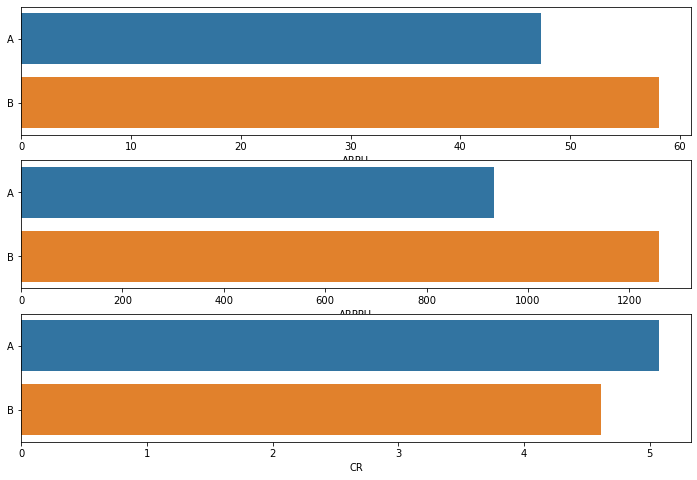

In [8]:
make_graphs(metrics)